# Usefull Time series related blogs 2

## Forecasting with Trees: Hybrid Modeling for Time Series

Tree-based algorithms are well-known in the machine learning ecosystem. By far, they are famous to dominate the approach of every tabular supervised task. Given a tabular set of features and a target to predict, they can achieve satisfactory results without so much effort or particular preprocessing. The splitting criterion, at the basis of their learning procedure, it’s effective to focus only on the relevant features and on the range of useful values.

The weak spot of tree-based models is that they technically can’t extrapolate on higher/lower feature values than seen in training data. It is almost impossible for them to predict values outside the seen interval. On the contrary, classical linear regression may suffer less the dynamic behaviors of data. **Since linear regression excels at extrapolating trends while gradient boosting excels at learning interactions, why not combine them?** We aim to create “hybrid” forecasters that combine complementary learning algorithms and let the strengths of one make up for the weakness of the other.

It’s easier to think about ‘hybrid models’ when working with deep learning. The infinite architecture combinations and the personalized training process of neural networks provide great benefits in terms of customizations (as an example, Exponential Smoothing stacked with LSTM). Developing customized hybrid solutions with tree models is trickier. A good resource in this sense is represented by linear-tree: a python package that provides hybrid models architectures that mix the learning ability of tree-based and linear models. Not only, but also LGBM or XGBoost have introduced the ability to fit gradient boosting with linear approximations in the tree leaves.

### Experiment Setup

To design effective hybrids, we need a general understanding of how time series are constructed. Many time series can be closely described by adding together just three components (trend, season, and cycles) plus an essentially unpredictable term (error).

$$ series = trend + seasons + cycles + error $$

Learning the time series components could be figured out as an iterative procedure:
- firstly, learn the trend and subtract it out from the original series to get the series of residuals;
- secondly, learn the seasonality from the detrended residuals and subtract the seasons out;
- in the end, learn the cycles and subtract the cycles out.

In other words, we use one algorithm to fit the specific component series and then a second one to fit the residual series. The final forecast is the addition of the predictions of the various model components.

To experiment with the building of hybrids, we start generating some simulated series with a double seasonality pattern and a trend component.

In [1]:
import numpy as np 
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import SplineTransformer
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score

from lightgbm import LGBMRegressor

In [2]:
### UTLITY FUNCTIONS FOR SYNTETIC DATA GENERATION ###

def gen_sinusoidal(timesteps, amp, freq, noise):
    
    X = np.arange(timesteps)
    e = np.random.normal(0,noise, (timesteps,))
    y = amp*np.sin(X*(2*np.pi/freq))+e
    
    return y


def gen_randomwalk(timesteps, noise):

    y = np.random.normal(0,noise, (timesteps,))
    
    return y.cumsum()

The unknown trend is obtained fitting a cubic polynomial on a random walk series. The result is a smoothed trend line which is added to the seasonal component to obtain the final time series to forecast. We generate multiple time series, in this way, and try to forecast them benchmarking various solutions.

In [3]:
### SYNTETIC DATA GENERATION ###

df = {}
n_series = 100
timesteps = 2_000
for i in range(n_series):
    
    np.random.seed(i)
    seas1 = gen_sinusoidal(timesteps=timesteps, amp=10, freq=24, noise=4)
    seas2 = gen_sinusoidal(timesteps=timesteps, amp=10, freq=24*7, noise=4)
    
    rw = gen_randomwalk(timesteps=timesteps, noise=1)
    X = np.linspace(0,10, timesteps).reshape(-1,1)
    X = np.power(X, [1,2,3])
    m = LinearRegression()
    trend = m.fit(X, rw).predict(X)

    df[f'ts_{i}'] = seas1 + seas2 + trend
    
df = pd.DataFrame(df) + 3_000
df.shape

(2000, 100)

Text(0.5, 1.0, 'Seasonalities + Trend')

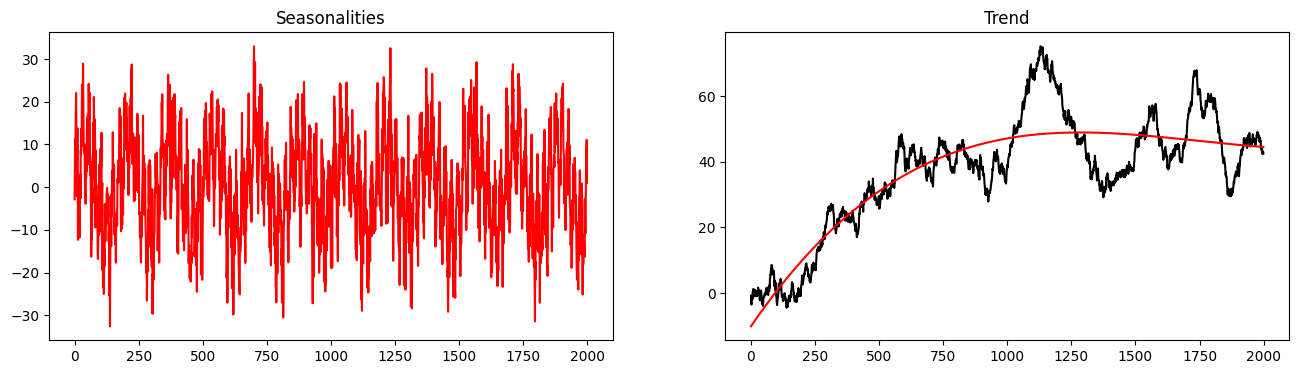

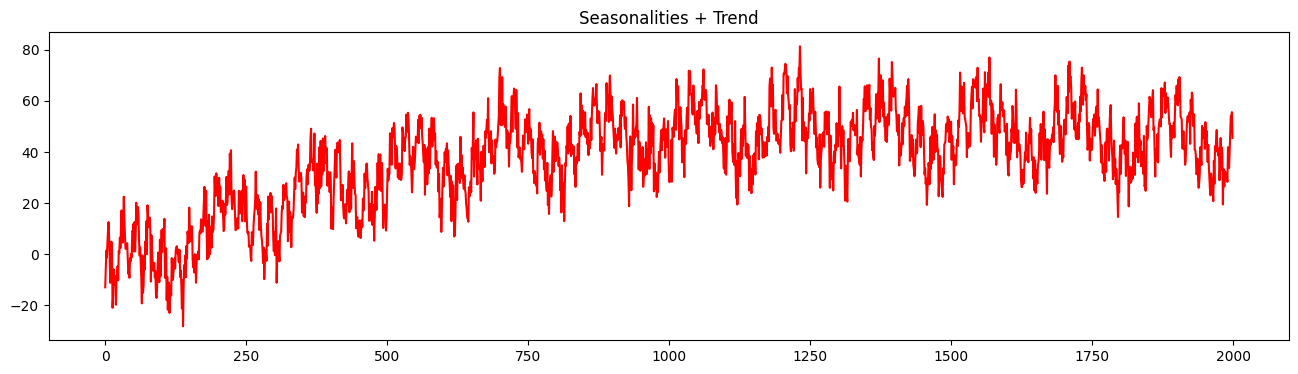

In [4]:
### EXAMPLE OF SYNTETIC DATA GENERATION ###

np.random.seed(1234)
seas1 = gen_sinusoidal(timesteps=timesteps, amp=10, freq=24, noise=4)
seas2 = gen_sinusoidal(timesteps=timesteps, amp=10, freq=24*7, noise=4)

rw = gen_randomwalk(timesteps=timesteps, noise=1)
X = np.linspace(0,10, timesteps).reshape(-1,1)
X = np.power(X, [1,2,3])
m = LinearRegression()
trend = m.fit(X, rw).predict(X)

plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(seas1 + seas2, c='red'); plt.title('Seasonalities')
plt.subplot(122)
plt.plot(rw, c='black'); plt.plot(trend, c='red'); plt.title('Trend')

plt.figure(figsize=(16,4))
plt.plot(seas1 + seas2 + trend, c='red'); plt.title('Seasonalities + Trend')

<AxesSubplot: >

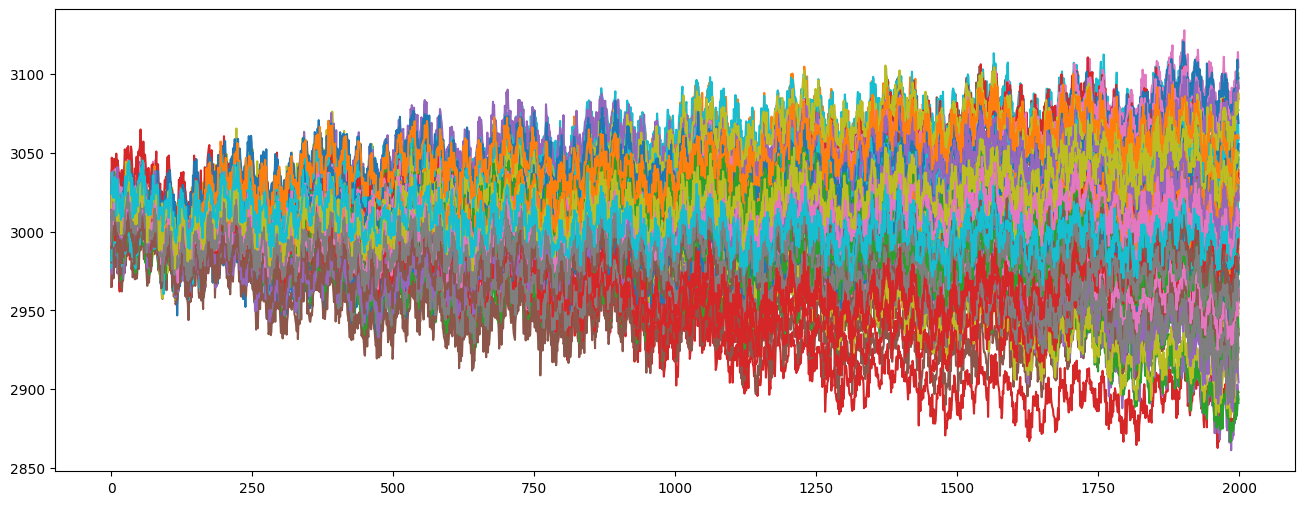

In [5]:
### PLOT GENERATED DATA ###

df.plot(legend=False, figsize=(16,6))

We try four different approaches:

- fit a naive linear model, after choosing the best polynomial basis;
- transform the target with a differencing transformation to make it stationary;
- **hybrid additive.** Firstly a linear model, with an optimal polynomial basis, is fitted to extrapolate the trend. Secondly, the detrended series is modeled with a gradient boosting;
- **hybrid inclusive.** Fit a gradient boosting including also the extrapolated trend (obtained fitting a linear model with an optimal polynomial basis) as a feature.

Except for the naive solution, all the approaches use as features some spline transformations. They are good to capture the seasonality patterns simply by looking at the series. The optimal trend is chosen by searching for the best polynomial basis on the training data. A gradient boosting is fitted, while searching for some optimal parameters configurations, using a temporal cross-validation strategy.

In [6]:
### FIT MODELS AND STORE RESULTS ###

mse_naive = []
mse_diff = []
mse_hybrid_add = []
mse_hybrid_incl = []

df_naive = (df*np.nan).copy()
df_diff = (df*np.nan).copy()
df_hybrid_add = (df*np.nan).copy()
df_hybrid_incl = (df*np.nan).copy()

ts = tqdm(df.columns)
for c in ts:
    
    y_test = df[c].tail(24*7*4)
    y_train = df[c][~df[c].index.isin(y_test.index)]
    X_train = np.arange(0, y_train.shape[0]).reshape(-1,1)
    X_test = np.arange(X_train[-1], X_train[-1]+y_test.shape[0]).reshape(-1,1)
    
    train_mask = df[c].index.isin(y_train.index)
    test_mask = df[c].index.isin(y_test.index)
    
    period = 24
    n_splines = 3
    n_knots = n_splines +1
    st24 = SplineTransformer(
        degree = 3,
        n_knots = n_knots,
        knots = np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation = "periodic",
        include_bias = True,
    )
    period = 168
    n_splines = 6
    n_knots = n_splines +1
    st168 = SplineTransformer(
        degree = 3,
        n_knots = n_knots,
        knots = np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation = "periodic",
        include_bias = True,
    )
    
    CV = TimeSeriesSplit(n_splits=4)
    base_model = LGBMRegressor(random_state=33, n_jobs=-1) 
    param_grid = {'n_estimators': [30,50,70,90,110,130]}
    
    trend2 = (-cross_val_score(
        LinearRegression(), np.power(X_train,[1,2]), y_train, 
        cv=CV, scoring='neg_mean_squared_error'
    )).mean()
    trend3 = (-cross_val_score(
        LinearRegression(), np.power(X_train,[1,2,3]), y_train, 
        cv=CV, scoring='neg_mean_squared_error'
    )).mean()
    
    powers = [1,2] if trend2 <= trend3 else [1,2,3]

    trend = LinearRegression() 
    trend.fit(np.power(X_train,powers), y_train)
    train_trend = trend.predict(np.power(X_train,powers))
    test_trend = trend.predict(np.power(X_test,powers))
    
    df_naive.loc[train_mask, c] = train_trend
    df_naive.loc[test_mask, c] = test_trend
    mse_naive.append(mse(y_test, trend.predict(np.power(X_test,powers))))
    score_naive = f"Naive Trend: {round(np.mean(mse_naive),3)}"
    
    X_train = np.hstack([st24.fit_transform(X_train), st168.fit_transform(X_train)])
    X_test = np.hstack([st24.transform(X_test), st168.transform(X_test)])
    
    model = GridSearchCV(base_model, param_grid=param_grid, cv=CV, scoring='neg_mean_squared_error')
    model.fit(X_train[1:], np.diff(y_train))
    
    df_diff.loc[train_mask, c] = np.cumsum(np.append(y_train.head(1), model.predict(X_train[1:])))
    df_diff.loc[test_mask, c] = np.cumsum(np.append(y_train.tail(1), model.predict(X_test)))[1:]
    mse_diff.append(mse(y_test, np.cumsum(np.append(y_train.tail(1), model.predict(X_test)))[1:]))
    score_diff = f"Differencing: {round(np.mean(mse_diff),3)}"
    
    model = GridSearchCV(base_model, param_grid=param_grid, cv=CV, scoring='neg_mean_squared_error')
    model.fit(X_train, y_train-train_trend)
    
    df_hybrid_add.loc[train_mask, c] = model.predict(X_train)+train_trend
    df_hybrid_add.loc[test_mask, c] = model.predict(X_test)+test_trend    
    mse_hybrid_add.append(mse(y_test, model.predict(X_test)+test_trend))
    score_hybrid_add = f"Hybrid Additive: {round(np.mean(mse_hybrid_add),3)}"
    
    X_train = np.hstack([train_trend.reshape(-1,1), X_train])
    X_test = np.hstack([test_trend.reshape(-1,1), X_test]) 
    
    model = GridSearchCV(base_model, param_grid=param_grid, cv=CV, scoring='neg_mean_squared_error')
    model.fit(X_train, y_train)
    
    df_hybrid_incl.loc[train_mask, c] = model.predict(X_train)
    df_hybrid_incl.loc[test_mask, c] = model.predict(X_test)     
    mse_hybrid_incl.append(mse(y_test, model.predict(X_test)))
    score_hybrid_incl = f"Hybrid Inclusive: {round(np.mean(mse_hybrid_incl),3)}"
    
    desc = f"{score_naive} | {score_diff} | {score_hybrid_add} | {score_hybrid_incl} |"
    ts.set_description(desc)

Naive Trend: 1353.755 | Differencing: 473.041 | Hybrid Additive: 1251.465 | Hybrid Inclusive: 427.517 |: 100%|██████████| 100/100 [53:35<00:00, 32.16s/it] 


The hybrid inclusive approach obtains the lowest mean test error, followed by the differencing method. The hybrid additive underperforms our expectations since it registers an error nearly three times higher than the differencing approach. Generally speaking, differencing the target is always a great benchmark when modeling dynamic systems (like the one presented in our experiment). The great surprise is represented by the huge difference in performances between the hybrid methods. Let’s visually inspect some results to see what may happen.

In [ ]:
### TEST ERROR DISTRIBUTIONS ###

scores = pd.DataFrame({
    f'{score_naive}': mse_naive,
    f'{score_diff}': mse_diff,
    f'{score_hybrid_add}': mse_hybrid_add,
    f'{score_hybrid_incl}': mse_hybrid_incl
})

scores.plot.box(figsize=(11,6), title='MSEs on Test', ylabel='MSE')

In [ ]:
### PLOT PREDICTIONS ###

c = 'ts_11' 

df[c].plot(figsize=(16,6), label='true', alpha=0.3, c='black')

df_diff[c].plot(figsize=(16,6), label='differencing pred', c='magenta')
df_hybrid_add[c].plot(figsize=(16,6), label='hybrid addictive pred', c='red')
df_hybrid_incl[c].plot(figsize=(16,6), label='hybrid inclusive pred', c='blue')
df_naive[c].plot(figsize=(16,6), label='trend pred', c='lime', linewidth=3)

plt.xlim(0, timesteps)
plt.axvspan(0, timesteps-test_mask.sum(), alpha=0.2, color='orange', label='TRAIN')
plt.axvspan(timesteps-test_mask.sum(), timesteps, alpha=0.2, color='green', label='TEST')
plt.legend()

In [ ]:
### PLOT PREDICTIONS ###

c = 'ts_33' 

df[c].plot(figsize=(16,6), label='true', alpha=0.3, c='black')

df_diff[c].plot(figsize=(16,6), label='differencing pred', c='magenta')
df_hybrid_add[c].plot(figsize=(16,6), label='hybrid addictive pred', c='red')
df_hybrid_incl[c].plot(figsize=(16,6), label='hybrid inclusive pred', c='blue')
df_naive[c].plot(figsize=(16,6), label='trend pred', c='lime', linewidth=3)

plt.xlim(0, timesteps)
plt.axvspan(0, timesteps-test_mask.sum(), alpha=0.2, color='orange', label='TRAIN')
plt.axvspan(timesteps-test_mask.sum(), timesteps, alpha=0.2, color='green', label='TEST')
plt.legend()

In [ ]:
### PLOT PREDICTIONS ###

c = 'ts_73' 

df[c].plot(figsize=(16,6), label='true', alpha=0.3, c='black')

df_diff[c].plot(figsize=(16,6), label='differencing pred', c='magenta')
df_hybrid_add[c].plot(figsize=(16,6), label='hybrid addictive pred', c='red')
df_hybrid_incl[c].plot(figsize=(16,6), label='hybrid inclusive pred', c='blue')
df_naive[c].plot(figsize=(16,6), label='trend pred', c='lime', linewidth=3)

plt.xlim(0, timesteps)
plt.axvspan(0, timesteps-test_mask.sum(), alpha=0.2, color='orange', label='TRAIN')
plt.axvspan(timesteps-test_mask.sum(), timesteps, alpha=0.2, color='green', label='TEST')
plt.legend()

From the above bunch of images, we can better understand the ‘failure’ of the additive approach. Its performances are strictly related to the goodness of the previous trend fit. If the trend estimates are inaccurate also the final forecastings are garbage. This behavior is mitigated by the inclusive hybrid approach since the trend is included as a feature in the model. Therefore the gradient boosting can correct/mitigate the final forecast errors.

## Time Series Forecasting with Feature Selection

When approaching for the first time a forecasting task, it’s a good practice to start adopting standard and baseline solutions. In the first part of the project, we must dedicate our time to understanding the business needs and conducting adequate explorative analyses. If we can’t wait to build a predictive model, the best option is to fit naive models. This also sounds good since it may help in understanding the data, adopting an adequate validation strategy, or introducing fancy ideas.

After this preliminary phase, **when we are more confident about the achieved results, we can focus more on the engineering choices to develop the most adequate solution**. There are a lot of activities we could optimize. From the data processing to the model inference, we have to take care lot of aspects to make our solution works the best.

Sometimes providing forecasts in a fast and effective way may be a need. In that case, we have to configure our pipeline to provide predictions in the fastest way while maintaining an adequate performance level. Retraining the models from scratch is important but not mandatory. Since it may not grant performance boost/stability, we risk wasting precious time on retraining every time we have to forecast. **The possibility to reuse models and make forecasts without a mandatory fit it’s the first advantage to speed up forecasting.**

At the same time, **we could increase the speed of forecasting with some simple yet effective tricks**. For example, everyone knows feature selection as a technique to reduce the feature dimensionality received as input by a predictive model. Feature selection is an important step in most machine learning pipelines applied with the primary scope to improve performance. **When discharging features we are reducing the complexity of a model resulting also in lower inference times.**



### Experiment Setup

We simulate multiple time series with an hourly frequency and a double seasonality (daily and weekly). We also add a trend, obtained from a smoothed random walk, to introduce a stochastic behavior.

The last parts of the series are used as a test set where we measure forecasting errors and the inference time required to make predictions. For our experiment, we simulate a hundred independent time series. We say “independent” since all the series are not related to each other despite they show very similar behaviors. In this way, we individually model them.

In [1]:
import numpy as np 
import pandas as pd 
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge

from tsprial.forecasting import ForecastingCascade, ForecastingChain

ModuleNotFoundError: No module named 'tsprial'

In [ ]:
### UTILITY FUNCTIONS TO SIMULATE TIME SERIES AND STORE FORECASTING METRICS ###

def gen_sinusoidal(timesteps, amp, freq, noise):
    X = np.arange(timesteps)
    e = np.random.normal(0,noise, (timesteps,))
    y = amp*np.sin(X*(2*np.pi/freq))+e
    return y

def gen_randomwalk(timesteps, noise):
    y = np.random.normal(0,noise, (timesteps,))
    return y.cumsum()

def gen_ts(timesteps, amp, freq, noise, random_state=0):
    np.random.seed(random_state)
    
    if isinstance(freq, (int,float)):
        seas = gen_sinusoidal(timesteps=timesteps, amp=amp, freq=freq, noise=noise)
    elif np.iterable(freq) and not isinstance(freq, str):
        seas = np.zeros(timesteps)
        for f in freq:
            if isinstance(f, (int,float)):
                seas += \
                    gen_sinusoidal(timesteps=timesteps, amp=amp, freq=f, noise=noise)
            else:
                raise ValueError("freq not understood.")
    else:
        raise ValueError("freq not understood.")
    
    rw = gen_randomwalk(timesteps=timesteps, noise=1)
    X = np.linspace(0,10, timesteps).reshape(-1,1)
    X = np.power(X, [1,2])
    trend = LinearRegression().fit(X, rw).predict(X)
    
    return seas + trend


def get_metrics(model, X, y, metrics=None):
    
    score = {
        'mse': [model.score(X, y, scoring='mse')],
        'mae': [model.score(X, y, scoring='mae')],
        'mape': [model.score(X, y, scoring='mape')],
        'rmse': [model.score(X, y, scoring='rmse')],
    }
    
    if metrics is not None:
        for metric,s in score.items():
            metrics[metric].extend(s)
    else:
        metrics = score
    
    return metrics